# Severe Weather Analysis and Forecasting with Python Tools
David John Gagne, National Center for Atmospheric Research

## Outline
1. Severe Weather Analysis
    1. Upper Air Analysis
    2. Surface Analysis
2. Severe Weather Forecasting
    1. NCAR Ensemble Forecast Analysis
    2. NCAR Ensemble Storm Objects
3. Severe Weather Verification
    1. Verifying the NCAR Ensemble Forecast

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## Upper Air Analysis
First, we will produce a gridded upper air analysis from sounding data. The Oklahoma Mesonet conveniently stores a large archive of upper air data on the mandatory pressure levels in ASCII table format. The pandas library is used to 
read in the data as shown below.

In [3]:
# Date of analysis. Modify to load a different day
analysis_date = pd.Timestamp("2017-04-02 12:00")
# Path to upper air files on the Oklahoma Mesonet website
web_path = "http://www.mesonet.org/data/public/noaa/upperair/mdf/"
# Pandas can read local or web-based tables depending on the path you pass
# The delim_whitespace reads files with uneven spacing between items, like the Mesonet files
upper_air = pd.read_table(web_path + "{0}/{1}00.mdf".format(analysis_date.strftime("%Y/%m/%d"),
                                                            analysis_date.strftime("%Y%m%d%H")),
                          skiprows=2, 
                          delim_whitespace=True, na_values=[-996, -997, -998, -999])
# The file contains global observations. We just want to produce an analysis of obs over the US, so we
# filter out non-North American points. I call pd.DataFrame around it to explicitly make a copy of the DataFrame.
upper_air_us = pd.DataFrame(upper_air.loc[(upper_air["LON"] > -125) & (upper_air["LON"] < -60) & 
                                          (upper_air["LAT"] > 20) & (upper_air["LAT"] < 55), :])

The upper air data are stored in a pandas DataFrame. A DataFrame acts like a database. Each row contains a single record of an event, and each column contains data about a particular variable. Columns can have different datatypes, like str, float, and int. Below is a summary of the upper_air_us DataFrame.

In [23]:
upper_air_us

,STID,STNM,TIME,LAT,LON,ELEV,TAIR_SFC,TDEW_SFC,WDIR_SFC,WSPD_SFC,...,WDIR_150,WSPD_150,HGHT_150,TAIR_100,TDEW_100,WDIR_100,WSPD_100,HGHT_100,X,Y
343,CWSE,957,720,53.53,-114.10,766.0,-3.3,-5.0,120.0,5.0,...,240.0,42.0,13410,-52.7,-85.6,270.0,25.0,16020,1.422195e+06,3.330938e+06
344,CYLW,962,720,49.97,-119.38,430.0,6.2,-0.7,210.0,6.0,...,250.0,26.0,13440,-56.9,-88.8,245.0,33.0,16060,9.672966e+05,2.998928e+06
345,CWSA,964,720,43.93,-60.01,4.0,-3.9,-11.8,320.0,18.0,...,300.0,47.0,13440,-53.1,-85.0,275.0,32.0,16080,5.546368e+06,2.675023e+06
346,CYQI,965,720,43.86,-66.10,9.0,-8.7,-13.3,0.0,0.0,...,310.0,58.0,13550,-56.7,-88.6,310.0,41.0,16140,5.083164e+06,2.502910e+06
347,CWMW,971,720,46.38,-75.96,173.0,-4.1,-5.0,160.0,5.0,...,310.0,73.0,13600,-60.9,-91.8,310.0,49.0,16180,4.250361e+06,2.575805e+06
348,CYZV,973,720,50.21,-66.25,53.0,-21.1,-25.9,10.0,2.0,...,320.0,48.0,13370,-52.1,-85.0,300.0,37.0,16010,4.852395e+06,3.188551e+06
350,CYYR,975,720,53.30,-60.36,36.0,-18.7,-27.6,220.0,4.0,...,295.0,36.0,13220,-48.5,-82.4,280.0,15.0,15910,5.134128e+06,3.668907e+06
351,CYAH,977,720,53.75,-73.66,307.0,-6.7,-8.5,185.0,18.0,...,295.0,42.0,13340,-53.3,-86.2,290.0,37.0,15980,4.228892e+06,3.444064e+06
352,CYMO,978,720,51.26,-80.65,10.0,0.2,-1.7,140.0,2.0,...,295.0,54.0,13460,-55.7,-83.6,270.0,46.0,16070,3.798167e+06,3.060102e+06
353,CWPL,980,720,51.45,-90.20,386.0,-3.9,-6.2,30.0,12.0,...,285.0,58.0,13480,-57.5,-89.4,255.0,54.0,16100,3.107079e+06,3.001877e+06


### Important Attributes of DataFrames
* `upper_air_us.columns`: Outputs a list of all the columns in a DataFrame
* `upper_air_us.index`: Outputs a list of all the indices. Columns and indices can be integers or strings.
* `upper_air_us.loc[index_ids, column_ids]`: Access a subset of the DataFrame with the right index and column ids
* `upper_air_us.iloc[index_integer_values, column_integer_values]`: Access of a subset of the DataFrame with integer indices.

In [4]:
# Print out all the columns
print(upper_air_us.columns)
# What if we want to identify a subset of columns with a shared property? 
# We can use a pandas str operations to filter the column names.
# Here we find all the temperature columns
temp_columns = upper_air_us.columns[upper_air_us.columns.str.contains("TAIR")]
print(temp_columns)
# We can now calculate the mean temperature across all sites in each column
print(upper_air_us[temp_columns].mean())

Index(['STID', 'STNM', 'TIME', 'LAT', 'LON', 'ELEV', 'TAIR_SFC', 'TDEW_SFC',
       'WDIR_SFC', 'WSPD_SFC', 'PRES_SFC', 'TAIR_1000', 'TDEW_1000',
       'WDIR_1000', 'WSPD_1000', 'HGHT_1000', 'TAIR_925', 'TDEW_925',
       'WDIR_925', 'WSPD_925', 'HGHT_925', 'TAIR_850', 'TDEW_850', 'WDIR_850',
       'WSPD_850', 'HGHT_850', 'TAIR_700', 'TDEW_700', 'WDIR_700', 'WSPD_700',
       'HGHT_700', 'TAIR_500', 'TDEW_500', 'WDIR_500', 'WSPD_500', 'HGHT_500',
       'TAIR_400', 'TDEW_400', 'WDIR_400', 'WSPD_400', 'HGHT_400', 'TAIR_300',
       'TDEW_300', 'WDIR_300', 'WSPD_300', 'HGHT_300', 'TAIR_250', 'TDEW_250',
       'WDIR_250', 'WSPD_250', 'HGHT_250', 'TAIR_200', 'TDEW_200', 'WDIR_200',
       'WSPD_200', 'HGHT_200', 'TAIR_150', 'TDEW_150', 'WDIR_150', 'WSPD_150',
       'HGHT_150', 'TAIR_100', 'TDEW_100', 'WDIR_100', 'WSPD_100', 'HGHT_100'],
      dtype='object')
Index(['TAIR_SFC', 'TAIR_1000', 'TAIR_925', 'TAIR_850', 'TAIR_700', 'TAIR_500',
       'TAIR_400', 'TAIR_300', 'TAIR_250', 'TAIR_

## Exercise 1
Calculate the maximum wind speed at the surface and each pressure level. 

In [42]:
# Fill in your answer here

## Creating an Analysis
Most observations of the atmosphere are collected at discrete locations and times, but we want to know what the weather is like at any point on the globe and at any time. An analysis is our best guess at what weather conditions are like at a given location based on the information we have available. An analysis is produced by using observations to update a background state. The background state can be anything from the mean of the observations to the forecast from a numerical weather prediction model. There is a whole subfield of meteorology dedicated to generating analyses called Data Assimilation. 

There are many analysis techniques with varying levels of complexity and statistical soundness. Today we will demonstrate a technique popular among statisticians called Gaussian Process Regression (also known as kriging). It is a way to interpolate and extrapolate among data points based on the spatial relationships among the observations.

### Gaussian Process Procedure
1. Inputs: coordinates of each observation and the observations themselves
2. Normalize input observations (subtract mean and divide that by the standard deviation)
3. Transform the observations using a kernel that performs some kind of distance-based transformation
4. Solve a linear system of equations to estimate contribution of each observation to a smooth linear function describing a field
5. Use the kernel transformation on the coordinates of the interpolation locations to calculate how much each observation site contributes to the value of the prediction at that site.
6. Find the dot product of the observation weights and influence matrix to determine the interpolated value.
7. Rescale the interpolated values.

## Example: 500 mb Height
We will now create a grid of 500 mb heights from observations over the US.

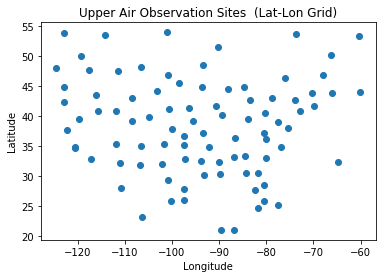

In [5]:
plt.scatter(upper_air_us["LON"], upper_air_us["LAT"])
plt.title("Upper Air Observation Sites  (Lat-Lon Grid)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

First we project the data onto a flat surface using a Lambert Conformal Conic Projection.

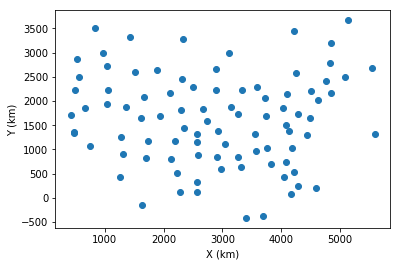

In [6]:
bmap = Basemap(projection="lcc", resolution="l", lon_0=-97, lat_0=35, 
               llcrnrlon=-122, llcrnrlat=22, urcrnrlon=-56, urcrnrlat=50)
x, y = bmap(upper_air_us["LON"].values, upper_air_us["LAT"].values)
upper_air_us.loc[:, "X"] = x
upper_air_us.loc[:, "Y"] = y
plt.scatter(x / 1000, y / 1000)
plt.xlabel("X (km)")
plt.ylabel("Y (km)")

Then we create our analysis grid by specifying the range of latitude and longitude values and the spacing.

In [7]:
lons = np.arange(-140, -50, 0.5)
lats = np.arange(20, 58, 0.5)
lon_grid, lat_grid = np.meshgrid(lons, lats)
x_grid, y_grid = bmap(lon_grid, lat_grid)

Now we normalize the data and generate the analysis using the scikit-learn GaussianProcessRegressor program.

In [8]:
# Convert to height to decameters
upper_air_us["HGHT_500_dam"] = upper_air_us["HGHT_500"] / 10
gp_var = "HGHT_500_dam"
# Filter out nan values
valid = ~np.isnan(upper_air_us[gp_var].values)
# Calculate mean and standard deviation of heights for normalization
mean = upper_air_us.loc[valid, gp_var].mean()
sd = upper_air_us.loc[valid, gp_var].std()
print(mean, sd)
# Fit GaussianProcessRegressor and provide initial length_scale and alpha (additive noise to obs)
gp = GaussianProcessRegressor(kernel=RBF(length_scale=100), alpha=0.01)
gp.fit(upper_air_us.loc[valid, ["X", "Y"]] / 1000, (upper_air_us.loc[valid, gp_var] - mean) / sd)
vals, vals_sd = gp.predict(np.vstack((x_grid.ravel(), y_grid.ravel())).T / 1000, return_std=True)

565.2873563218391 14.151923236853415


Now we plot the 500 mb contours and the analysis standard deviation.

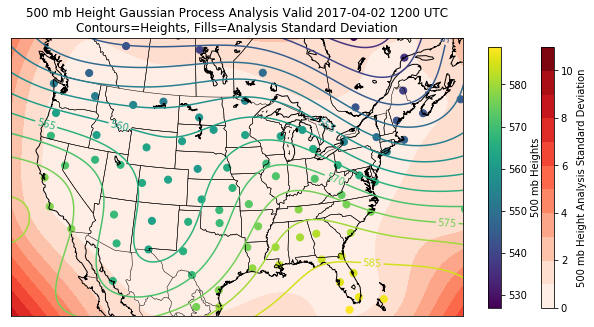

In [9]:
plt.figure(figsize=(10, 6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
height_contours = plt.contour(x_grid, y_grid, 
                              (vals.reshape(lon_grid.shape) * sd + mean), np.arange(520, 595, 5))
plt.clabel(height_contours, fmt="%d")
sd_fills = plt.contourf(x_grid, y_grid, vals_sd.reshape(lon_grid.shape) * sd, np.arange(0, 12, 1), cmap="Reds")
station_heights = plt.scatter(x[valid], y[valid], 50, upper_air_us.loc[valid, gp_var])
plt.colorbar(sd_fills, shrink=0.8, fraction=0.05, label="500 mb Height Analysis Standard Deviation")
plt.colorbar(station_heights, shrink=0.8, fraction=0.05, label="500 mb Heights")
plt.title("500 mb Height Gaussian Process Analysis Valid {0}\nContours=Heights, Fills=Analysis Standard Deviation".format(analysis_date.strftime("%Y-%m-%d %H%M UTC")))
plt.savefig("{0}_gp_analysis.png".format(gp_var), dpi=200, bbox_inches="tight")

What does the analysis process visually resemble for a given point? An example is shown below.

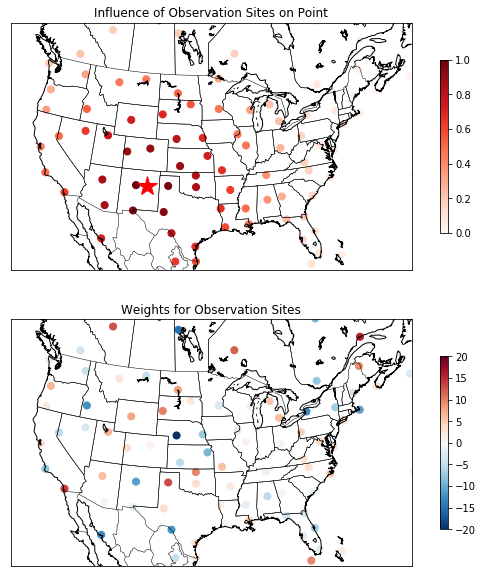

In [10]:
k = gp.kernel_(np.vstack((x_grid.ravel(), y_grid.ravel())).T / 1000, 
                          upper_air_us.loc[valid, ["X", "Y"]] / 1000)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax in axes:
    bmap.drawstates(ax=ax)
    bmap.drawcoastlines(ax=ax)
    bmap.drawcountries(ax=ax)
axes[0].plot(x_grid.ravel()[70 + 30 * 180], y_grid.ravel()[70 + 30 * 180], "r*", ms=20)
dist_points = axes[0].scatter(x[valid], y[valid], 50, k[70 + 30 * 180], cmap="Reds", vmax=1, vmin=0)
plt.colorbar(dist_points, ax=axes[0], shrink=0.7)
axes[0].set_title("Influence of Observation Sites on Point")
weights = axes[1].scatter(x[valid], y[valid], 50, gp.alpha_, vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar(weights, ax=axes[1], shrink=0.7)
axes[1].set_title("Weights for Observation Sites")

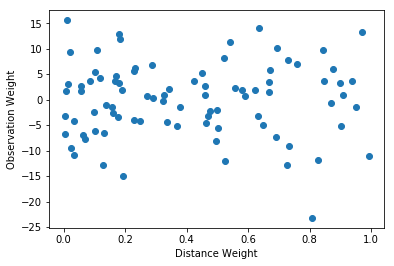

In [12]:
plt.plot(k[70 + 30 * 180], gp.alpha_, 'o')
plt.xlabel("Distance Weight")
plt.ylabel("Observation Weight")

### Exercise 2
Create an combined analysis of height, temperature, dewpoint, and wind speed at a single pressure level and plot it. Describe what important synoptic weather features you see and their implications for severe weather.

In [ ]:
# Insert your code here.


Write your discussion in this cell starting here:
...